In [35]:
from pyhere import here
import os

os.chdir(here())


In [36]:
from pathlib import Path
import pickle
import pandas as pd
import xarray as xr
import rioxarray as rxr


def load_model_index(models_dir):
    """Load the index of available models."""
    models_dir = Path(models_dir)
    index_path = models_dir / "model_index.csv"
    
    if not index_path.exists():
        raise FileNotFoundError(f"Model index not found at {index_path}")
    
    return pd.read_csv(index_path)


def filter_models(model_index, species=None, activity_types=None):
    """Filter models based on species and activity types."""
    filtered_index = model_index.copy()
    
    if species:
        filtered_index = filtered_index[filtered_index.latin_name.isin(species)]
    
    if activity_types:
        filtered_index = filtered_index[filtered_index.activity_type.isin(activity_types)]
    
    return filtered_index


def load_model(model_path):
    """Load a trained model from disk."""
    with open(model_path, "rb") as f:
        model = pickle.load(f)
    return model


def load_ev_df(evs_path: str) -> pd.DataFrame:
    """Load environmental variables as a DataFrame."""
    print(f"Loading environmental variables from {evs_path}")
    evs = rxr.open_rasterio(evs_path, masked=True, band_as_variable=True).squeeze()
    
    # Rename the variables by their long name
    for var in evs.data_vars:
        evs = evs.rename({var: evs[var].attrs["long_name"]})
    
    # Convert to DataFrame
    ev_df = evs.to_dataframe()
    if 'spatial_ref' in ev_df.columns:
        ev_df.drop("spatial_ref", axis=1, inplace=True)
    ev_df.dropna(inplace=True)

    return ev_df


In [37]:
model_index = load_model_index("data/sdm_models")

In [40]:
results_path =  "data/sdm_predictions/results.pkl"

training_results = pd.read_pickle(results_path)

In [41]:
training_results.head()

,latin_name,activity_type,occurrence,final_model,cv_models,cv_scores,n_presence,n_background,mean_cv_score,std_cv_score,folds,prediction_path
0,Nyctalus noctula,In flight,climate_stats_temp_ann_var climate_bio...,"(StandardScaler(), MaxentModel(beta_multiplier...","[(StandardScaler(), MaxentModel(beta_multiplie...","[0.6248725517933498, 0.759132584140488, 0.7544...",364,20976,0.713,0.062,3,data/sdm_predictions/Nyctalus noctula_In fligh...
1,Nyctalus noctula,Roost,climate_stats_temp_ann_var climate_bio...,"(StandardScaler(), MaxentModel(beta_multiplier...","[(StandardScaler(), MaxentModel(beta_multiplie...","[0.5956325301204819, 0.5599906558958283, 0.692...",80,20976,0.616,0.056,3,data/sdm_predictions/Nyctalus noctula_Roost.tif
2,Pipistrellus pipistrellus,In flight,climate_stats_temp_ann_var climate_bio...,"(StandardScaler(), MaxentModel(beta_multiplier...","[(StandardScaler(), MaxentModel(beta_multiplie...","[0.6839694678907705, 0.7053527495669973, 0.559...",1411,20976,0.650,0.064,3,data/sdm_predictions/Pipistrellus pipistrellus...
3,Pipistrellus pipistrellus,Roost,climate_stats_temp_ann_var climate_bio...,"(StandardScaler(), MaxentModel(beta_multiplier...","[(StandardScaler(), MaxentModel(beta_multiplie...","[0.6971443110230007, 0.7633808761862723, 0.711...",1879,20976,0.724,0.028,3,data/sdm_predictions/Pipistrellus pipistrellus...
4,Pipistrellus pygmaeus,In flight,climate_stats_temp_ann_var climate_bio...,"(StandardScaler(), MaxentModel(beta_multiplier...","[(StandardScaler(), MaxentModel(beta_multiplie...","[0.7309209718983924, 0.5362566146036478, 0.674...",354,20976,0.647,0.082,3,data/sdm_predictions/Pipistrellus pygmaeus_In ...


In [6]:
training_results.occurrence[0].head()


,climate_stats_temp_ann_var,climate_bioclim_bio_7,terrain_dtm,climate_stats_prec_ann_avg,climate_stats_temp_ann_avg,ceh_landcover_wetland,os_distance_distance_to_buildings,climate_bioclim_bio_9,bgs_coast_distance_to_coast,ceh_landcover_upland_heathland,...,ceh_landcover_broadleaved_woodland_500m,vom_vegetation_height_mean_500m,ceh_landcover_suburban_500m,os_cover_water_500m,ceh_landcover_coniferous_woodland_500m,ceh_landcover_urban_500m,ceh_landcover_improved_grassland_500m,geometry,class,sample_weight
0,4.370765,19.998690,17.848902,50.666668,9.105128,0.0,155.482239,5.669543,49204.152344,0.0,...,1450.0,2.058665,139.0,2.73,391.0,20.0,6621.0,POINT (465350 457750),1,4.417294
1,4.276229,19.274574,29.562792,53.916668,9.131839,0.0,152.125107,5.730516,56518.128906,0.0,...,2267.0,1.776723,49.0,25.67,73.0,140.0,2726.0,POINT (429550 477250),1,1.083524
2,4.431757,20.190638,32.155224,52.666668,9.072345,0.0,154.996857,5.515133,57473.800781,0.0,...,312.0,0.395401,129.0,0.99,0.0,122.0,1210.0,POINT (446450 435450),1,0.582465
3,4.357553,19.600000,13.160098,51.833332,9.159181,0.0,58.970009,5.700272,61011.398438,0.0,...,339.0,1.336935,4514.0,5.96,0.0,1527.0,2002.0,POINT (439650 467050),1,0.935982
4,4.328190,19.400000,18.213825,52.500000,9.191693,0.0,186.557541,5.745793,61079.117188,0.0,...,124.0,0.715464,249.0,8.96,0.0,168.0,3802.0,POINT (433250 470250),1,0.846229


In [7]:
i = 0

def get_artifacts(results_df, idx):
    latin_name = results_df.latin_name[idx]
    activity_type = results_df.activity_type[idx]


    model = results_df.final_model[idx]
    occurrence = results_df.occurrence[idx]
    
    return latin_name, activity_type, model, occurrence

non_X_cols = ["geometry", "class", "sample_weight"]
def prep_training_data(occurrence, non_X_cols=["geometry", "class", "sample_weight"]):
    """Prepare training data for modeling."""
    X = occurrence.drop(columns=non_X_cols)
    y = occurrence["class"]
    sample_weight = occurrence["sample_weight"]

    return X, y, sample_weight

X, _, _ = prep_training_data(training_results.occurrence[0])
X_cols = X.columns

In [14]:
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
import numpy as np


def compute_permutation_importance(
    model, X, y, sample_weight, max_samples=1000, n_repeats=10
):
    # 3. Compute permutation importance on held-out data
    result = permutation_importance(
        estimator=model,
        X=X,
        y=y,
        sample_weight=sample_weight,
        n_repeats=n_repeats,  # how many shuffles per feature
        random_state=0,
        max_samples=max_samples,
    )

    return result


def get_feature_names(estimator) -> list[str]:
    """Get feature names from the model."""
    if "feature_selector" in estimator.named_steps:
        feature_selector : ColumnTransformer = estimator.named_steps["feature_selector"]
        if hasattr(feature_selector, "get_feature_names_out"):
            return list(feature_selector.get_feature_names_out())
        else:
            raise ValueError("Feature selector does not have feature names.")
    elif hasattr(estimator, "feature_names_in_"):
        return estimator.feature_names_in_
    else:
        raise ValueError("Estimator does not have feature names.")

In [15]:
from tqdm.notebook import tqdm
results = []

for i in tqdm(range(len(training_results)), desc="Processing models"):
    latin_name, activity_type, model, occurrence = get_artifacts(training_results, i)
    print(f"Processing {latin_name} - {activity_type}")
    
    
    # 2. Prepare the training data
    X, y, sample_weight = prep_training_data(occurrence)

    try:
        feature_names = get_feature_names(model)
    except ValueError as e:
        print(f"Error getting feature names: {e}")
        feature_names = X.columns
    
    # 3. Compute permutation importance on held-out data
    result = compute_permutation_importance(model, X, y, sample_weight, max_samples=2000, n_repeats=10)
    
    results.append(
        (latin_name, activity_type, result["importances_mean"], result["importances_std"], feature_names)
    )

Processing models:   0%|          | 0/17 [00:00<?, ?it/s]

Processing Nyctalus noctula - In flight
Processing Nyctalus noctula - Roost
Processing Pipistrellus pipistrellus - In flight
Processing Pipistrellus pipistrellus - Roost


KeyboardInterrupt: 

In [ ]:
# compose the results into a DataFrame
results_df = pd.DataFrame(
    results, columns=["latin_name", "activity_type", "importances_mean", "importances_std", "variable"]
)

In [ ]:
results_df = results_df.explode(
    ["variable", "importances_mean", "importances_std"]
)

In [ ]:
results_df.head()

,latin_name,activity_type,importances_mean,importances_std,variable
0,Nyctalus noctula,In flight,0.002069,0.003915,climate_stats_temp_ann_var
0,Nyctalus noctula,In flight,0.015817,0.008904,climate_bioclim_bio_7
0,Nyctalus noctula,In flight,-0.003649,0.003391,terrain_dtm
0,Nyctalus noctula,In flight,0.005746,0.002738,climate_stats_prec_ann_avg
0,Nyctalus noctula,In flight,0.019624,0.009354,climate_stats_temp_ann_avg


In [ ]:
results_df.groupby(["variable"]).importances_mean.mean().sort_values(ascending=True).head(20)

variable
ceh_landcover_wetland                     -0.00723
os_distance_distance_to_water            -0.006893
ceh_landcover_wetland_500m                -0.00669
ceh_landcover_coniferous_woodland_500m   -0.006527
climate_bioclim_bio_8                    -0.006086
ceh_landcover_coniferous_woodland        -0.005263
ceh_landcover_upland_heathland_500m      -0.005227
ceh_landcover_upland_heathland           -0.005145
os_cover_water_500m                      -0.005013
terrain_stats_tpi                        -0.004947
terrain_stats_twi                        -0.004017
ceh_landcover_grassland_500m              -0.00335
ceh_landcover_urban_500m                 -0.003312
terrain_stats_aspect_eastness_slope      -0.002814
terrain_stats_aspect_northness_slope     -0.002484
vom_vegetation_height_mean               -0.002064
climate_stats_wind_ann_avg               -0.001803
vom_vegetation_height_max_500m           -0.001736
terrain_dtm                              -0.001691
os_distance_distance_t

In [ ]:
results_df["ci_lower"] = results_df["importances_mean"] - 1.96 * results_df["importances_std"]
results_df["negative"] = results_df["importances_mean"] < 0

results_df

,latin_name,activity_type,importances_mean,importances_std,variable,ci_lower,negative
0,Nyctalus noctula,In flight,0.002069,0.003915,climate_stats_temp_ann_var,-0.005604,False
0,Nyctalus noctula,In flight,0.015817,0.008904,climate_bioclim_bio_7,-0.001635,False
0,Nyctalus noctula,In flight,-0.003649,0.003391,terrain_dtm,-0.010296,True
0,Nyctalus noctula,In flight,0.005746,0.002738,climate_stats_prec_ann_avg,0.000381,False
0,Nyctalus noctula,In flight,0.019624,0.009354,climate_stats_temp_ann_avg,0.001291,False
...,...,...,...,...,...,...,...
16,Myotis mystacinus,Roost,0.019199,0.00719,ceh_landcover_suburban_500m,0.005106,False
16,Myotis mystacinus,Roost,-0.005993,0.001016,os_cover_water_500m,-0.007984,True
16,Myotis mystacinus,Roost,-0.004244,0.000414,ceh_landcover_coniferous_woodland_500m,-0.005054,True
16,Myotis mystacinus,Roost,-0.006915,0.001771,ceh_landcover_urban_500m,-0.010386,True


In [ ]:
fig_dir = Path("data/sdm_predictions/permutation_importance")
fig_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
from matplotlib import pyplot as plt

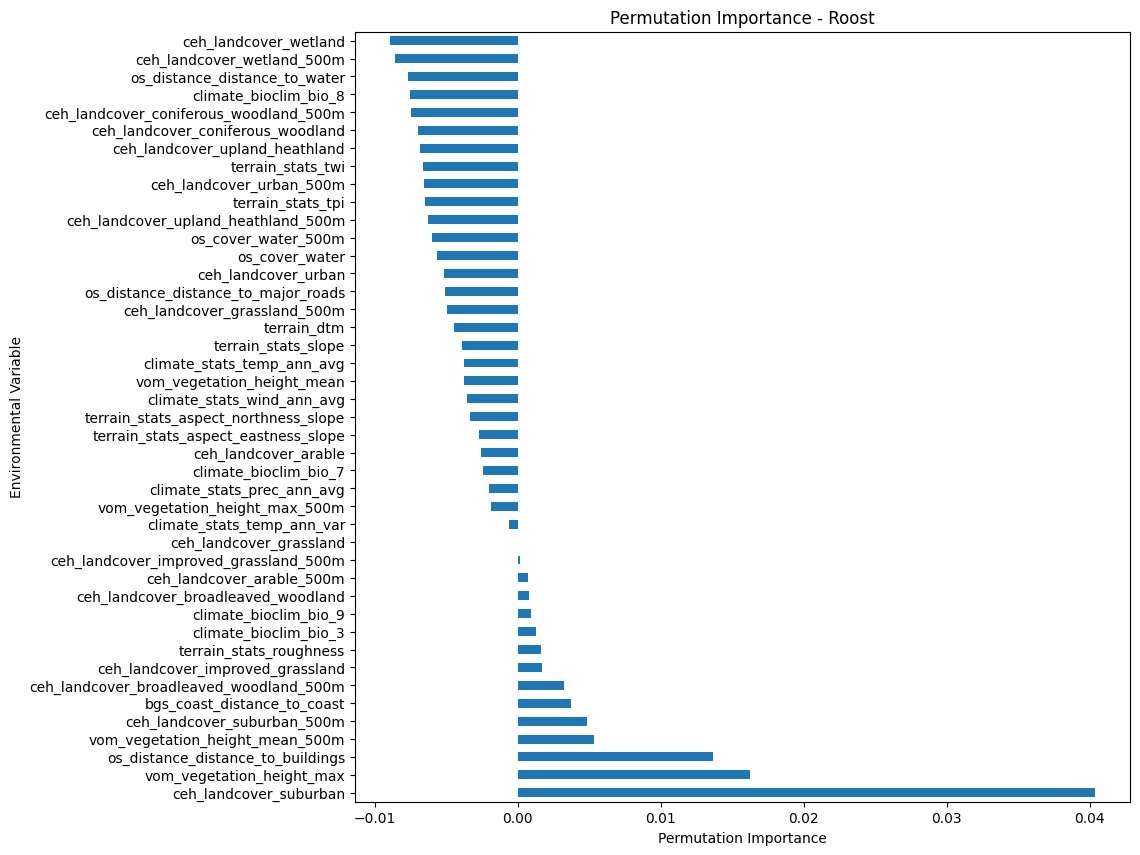

In [ ]:

fig = results_df[results_df["activity_type"] == "Roost"].groupby("variable").importances_mean.mean().sort_values(ascending=False).plot.barh(
    figsize=(10, 10),
    title="Permutation Importance - Roost",
    xlabel="Permutation Importance",
    ylabel="Environmental Variable",
)
# save the figure
plt.savefig(fig_dir / "mean_permutation_importance_roost.png", bbox_inches="tight")

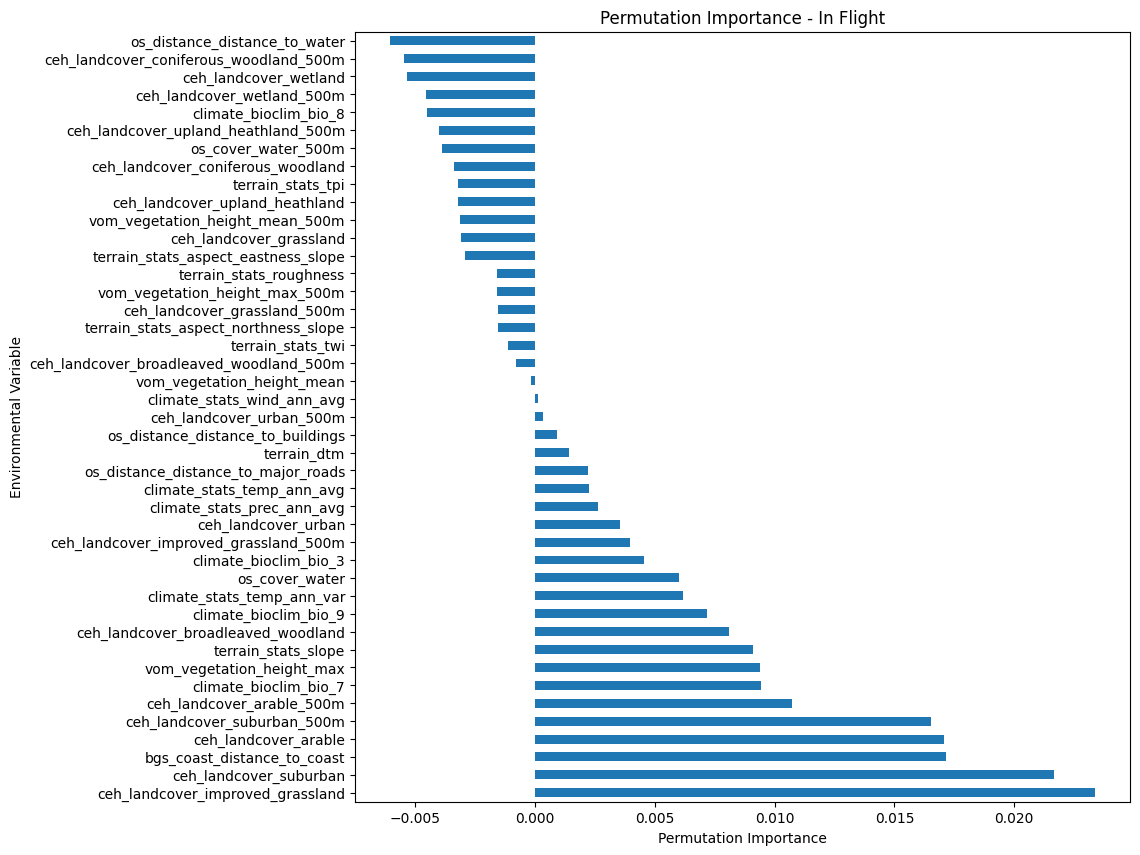

In [ ]:

fig = results_df[results_df["activity_type"] == "In flight"].groupby("variable").importances_mean.mean().sort_values(ascending=False).plot.barh(
    figsize=(10, 10),
    title="Permutation Importance - In Flight",
    xlabel="Permutation Importance",
    ylabel="Environmental Variable",
)
# save the figure
plt.savefig(fig_dir / "mean_permutation_importance_in_flight.png", bbox_inches="tight")

In [ ]:
# get a unique list of the latin_name and activity_type combinations
unique_combinations = results_df[["latin_name", "activity_type"]].drop_duplicates()
unique_combinations = unique_combinations.reset_index(drop=True)

# then iterate over the combinations 
# making a plot for each and saving it to the fig_dir

for i in tqdm(range(len(unique_combinations)), desc="Processing combinations"):
    fig = plt.figure()
    latin_name = unique_combinations.latin_name[i]
    activity_type = unique_combinations.activity_type[i]
    
    results_df[
        (results_df["latin_name"] == latin_name)
        & (results_df["activity_type"] == activity_type)
    ].groupby("variable").importances_mean.mean().sort_values(ascending=False).plot.barh(
        figsize=(10, 10),
        title=f"Permutation Importance - {latin_name} - {activity_type}",
        xlabel="Permutation Importance",
        ylabel="Environmental Variable",
        fig=fig,
    )
    
    # save the figure
    plt.savefig(fig_dir / f"mean_permutation_importance_{latin_name}_{activity_type}.png", bbox_inches="tight")
    plt.close(fig)


Processing combinations:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
results_df.to_csv(fig_dir / "permutation_importance.csv", index=False)

In [ ]:
activity_type_df = (
    results_df.groupby(["activity_type", "variable"])
    .importances_mean.mean()
    .sort_values(ascending=False)
    .to_frame()
    .reset_index()
)
activity_type_df["keep_var"] = activity_type_df.importances_mean > 0


activity_type_df.to_csv(fig_dir / "activity_type_df.csv", index=False)

activity_type_df.head()

,activity_type,variable,importances_mean,keep_var
0,Roost,ceh_landcover_suburban,0.04035,True
1,In flight,ceh_landcover_improved_grassland,0.023368,True
2,In flight,ceh_landcover_suburban,0.021649,True
3,In flight,bgs_coast_distance_to_coast,0.017139,True
4,In flight,ceh_landcover_arable,0.017059,True


In [ ]:
activity_type_df.query("activity_type == 'In flight' and keep_var").variable.tolist()

['ceh_landcover_improved_grassland',
 'ceh_landcover_suburban',
 'bgs_coast_distance_to_coast',
 'ceh_landcover_arable',
 'ceh_landcover_suburban_500m',
 'ceh_landcover_arable_500m',
 'climate_bioclim_bio_7',
 'vom_vegetation_height_max',
 'terrain_stats_slope',
 'ceh_landcover_broadleaved_woodland',
 'climate_bioclim_bio_9',
 'climate_stats_temp_ann_var',
 'os_cover_water',
 'climate_bioclim_bio_3',
 'ceh_landcover_improved_grassland_500m',
 'ceh_landcover_urban',
 'climate_stats_prec_ann_avg',
 'climate_stats_temp_ann_avg',
 'os_distance_distance_to_major_roads',
 'terrain_dtm',
 'os_distance_distance_to_buildings',
 'ceh_landcover_urban_500m',
 'climate_stats_wind_ann_avg']

In [28]:



with open("data/sdm_models/Myotis daubentonii_In flight_model.pkl", "rb") as f:
    model = pickle.load(f)



In [34]:
model.named_steps["feature_selector"].get_feature_names_out()

array(['selector__ceh_landcover_improved_grassland',
       'selector__ceh_landcover_suburban',
       'selector__bgs_coast_distance_to_coast',
       'selector__ceh_landcover_arable',
       'selector__ceh_landcover_suburban_500m',
       'selector__ceh_landcover_arable_500m',
       'selector__climate_bioclim_bio_7',
       'selector__vom_vegetation_height_max',
       'selector__terrain_stats_slope',
       'selector__ceh_landcover_broadleaved_woodland',
       'selector__climate_bioclim_bio_9',
       'selector__climate_stats_temp_ann_var', 'selector__os_cover_water',
       'selector__climate_bioclim_bio_3',
       'selector__ceh_landcover_improved_grassland_500m',
       'selector__ceh_landcover_urban',
       'selector__climate_stats_prec_ann_avg',
       'selector__climate_stats_temp_ann_avg',
       'selector__os_distance_distance_to_major_roads',
       'selector__terrain_dtm',
       'selector__os_distance_distance_to_buildings',
       'selector__ceh_landcover_urban_500m',
